# NIHAO_preparation

A tool to convert raw NIHAO simulation output into 1 single FITS file for stars and 1 for gas.
The simulation is repositioned and rotate to center face on on the main halo.
Important properties are converted both into physical units (e.g. Age in Gyr, velocity in km/s).
Elemental abundanes are reported as logarithmic number density ratios, consistent with Galactic spectroscopy.

Author: Sven Buder (ANU, sven.buder@anu.edu.au)

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# general packages
import numpy as np
from astropy.table import Table
from astropy.cosmology import Planck15 as cosmo

# pynbody
import pynbody as pb
from pynbody.snapshot.tipsy import TipsySnap

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams
rcParams['axes.labelsize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 20

panels = [
    'a)','b)','c)',
    'd)','e)','f)',
    'g)','h)','i)',
    'j)','k)','l)',
    'm)','n)','o)',
    'q)','r)','s)',
    't)','u)','v)',
    'w)','x)','y)',
    'z)','aa)','ab)',
    'ac)','ad)','ae)'
]

In [2]:
# Adjust this for your simulation.
# Files are expexted in 'NIHAO_raw/'+simulation_name+'/'+simulation_mass+'.'+simulation_snapshot
simulation_name = 'g8.26e11_extensive'
simulation_mass = 'g8.26e11'
simulation_snapshot = '01024'

# Read in full simulation
simulation_full = pb.load('NIHAO_raw/'+simulation_name+'/'+simulation_mass+'.'+simulation_snapshot)

# 1. Simulation vs. Main Halo (Dark Matter, Stars, Gas)

In [3]:
# Get an idea of how many halos have been identified in the simulation
simulation_halos = simulation_full.halos()
main_halo = simulation_halos[1]

pynbody.halo : An error occurred while reading substructure file. Falling back to using the halo info.


In [4]:
def hist2d_darkmatter_stars_gas(simulation, frame = 'xy', effective_radius = False, bins = 200, saveas=False):
    
    if frame == 'xy':
        pos_1 = 0
        pos_2 = 1
    elif frame == 'xz':
        pos_1 = 0
        pos_2 = 2
    elif frame == 'yz':
        pos_1 = 1
        pos_2 = 2
    else:
        raise ValueError('frame has to be xy, xz, or yz!')
    
    unit = 'kpc'
    xmin = np.min(simulation.dm['pos'][:,pos_1].in_units(unit))
    if xmin < -30000:
        unit = 'Mpc'

    xmedian = np.median(simulation.dm['pos'][:,pos_1].in_units(unit))
    ymedian = np.median(simulation.dm['pos'][:,pos_2].in_units(unit))
    
    xmin = np.min(simulation.dm['pos'][:,pos_1].in_units(unit) - xmedian)
    xmax = np.max(simulation.dm['pos'][:,pos_1].in_units(unit) - xmedian)
    ymin = np.min(simulation.dm['pos'][:,pos_2].in_units(unit) - ymedian)
    ymax = np.max(simulation.dm['pos'][:,pos_2].in_units(unit) - ymedian)
    
    if effective_radius:
        xmin = -effective_radius - xmedian
        xmax = effective_radius  - xmedian
        ymin = -effective_radius - ymedian
        ymax = effective_radius  - ymedian
    
    pos = ['X','Y','Z']
    
    f, gs = plt.subplots(1,3,figsize=(12,4.5),sharex=True,sharey=True)
    ax = gs[0]
    ax.text(0.04,0.95,panels[0],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_title('Dark Matter Density', fontsize=20)

    ax.hist2d(
        simulation.dm['pos'][:,pos_1].in_units(unit) - xmedian,
        simulation.dm['pos'][:,pos_2].in_units(unit) - ymedian,
        bins = (np.linspace(xmin,xmax,bins),np.linspace(ymin,ymax,bins)),
        cmin = 1, cmap = 'viridis',
        norm = LogNorm(),
    );
    ax.set_xlabel(pos[pos_1]+' / '+unit)
    ax.set_ylabel(pos[pos_2]+' / '+unit)
    
    ax = gs[1]
    ax.text(0.04,0.95,panels[1],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_title('Stellar Density', fontsize=20)

    ax.hist2d(
        simulation.s['pos'][:,pos_1].in_units(unit) - xmedian,
        simulation.s['pos'][:,pos_2].in_units(unit) - ymedian,
        bins = (np.linspace(xmin,xmax,bins),np.linspace(ymin,ymax,bins)),
        cmin = 1, cmap = 'cividis',
        norm = LogNorm(),
    );
    ax.set_xlabel(pos[pos_1]+' / '+unit)
    ax.set_ylabel(pos[pos_2]+' / '+unit)
    
    ax = gs[2]
    ax.text(0.04,0.95,panels[2],fontsize=15,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_title('Gas Density', fontsize=20)

    ax.hist2d(
        simulation.gas['pos'][:,pos_1].in_units(unit) - xmedian,
        simulation.gas['pos'][:,pos_2].in_units(unit) - ymedian,
        bins = (np.linspace(xmin,xmax,bins),np.linspace(ymin,ymax,bins)),
        cmin = 1, cmap = 'plasma',
        norm = LogNorm(),
    );
    ax.set_xlabel(pos[pos_1]+' / '+unit)
    ax.set_ylabel(pos[pos_2]+' / '+unit)
    plt.tight_layout()
    
    if saveas:
        plt.savefig('NIHAO_prepared/'+saveas + '.png', dpi=300, bbox_inches='tight')        
    plt.show()
    plt.close()

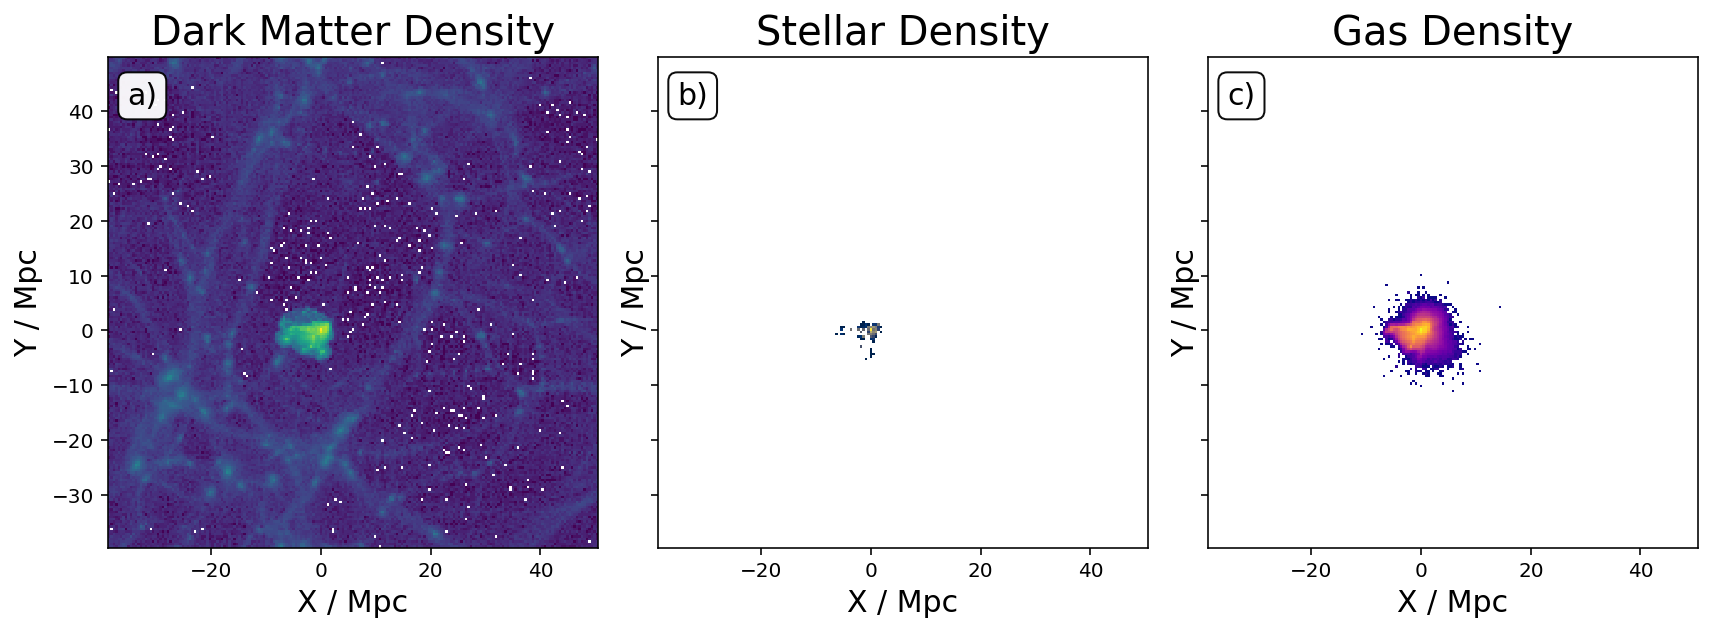

In [5]:
# Note: this is in the initial simulation frame, not yet rotated towards the main halo
hist2d_darkmatter_stars_gas(simulation_full, saveas=False)

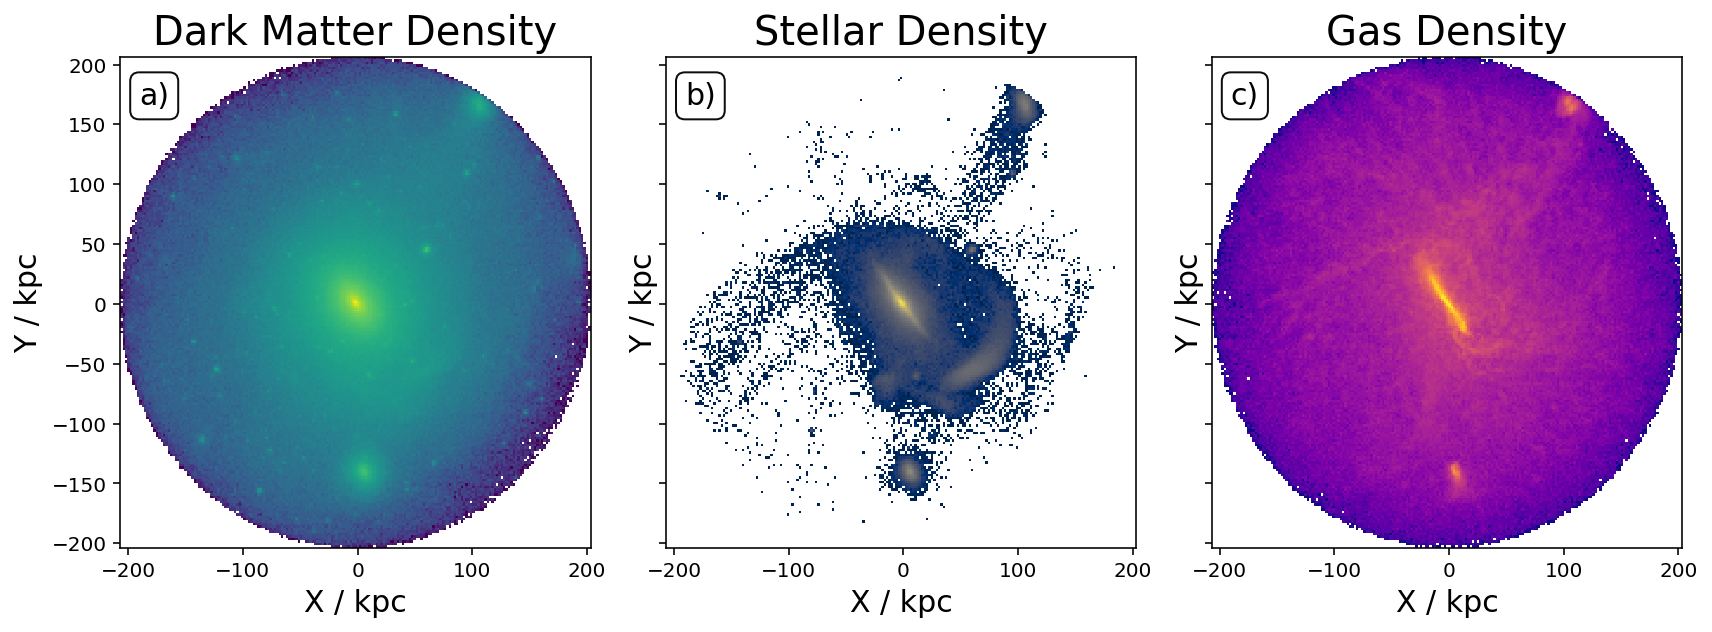

In [6]:
# Note: this is in the initial simulation frame, not yet rotated towards the main halo
hist2d_darkmatter_stars_gas(main_halo)

# 2. Coordinate Transformation towards face on Main Halo

In [7]:
# Reposition and rotate the simulation containing the main halo to see the main halo's disk face on.
pb.analysis.angmom.faceon(main_halo);

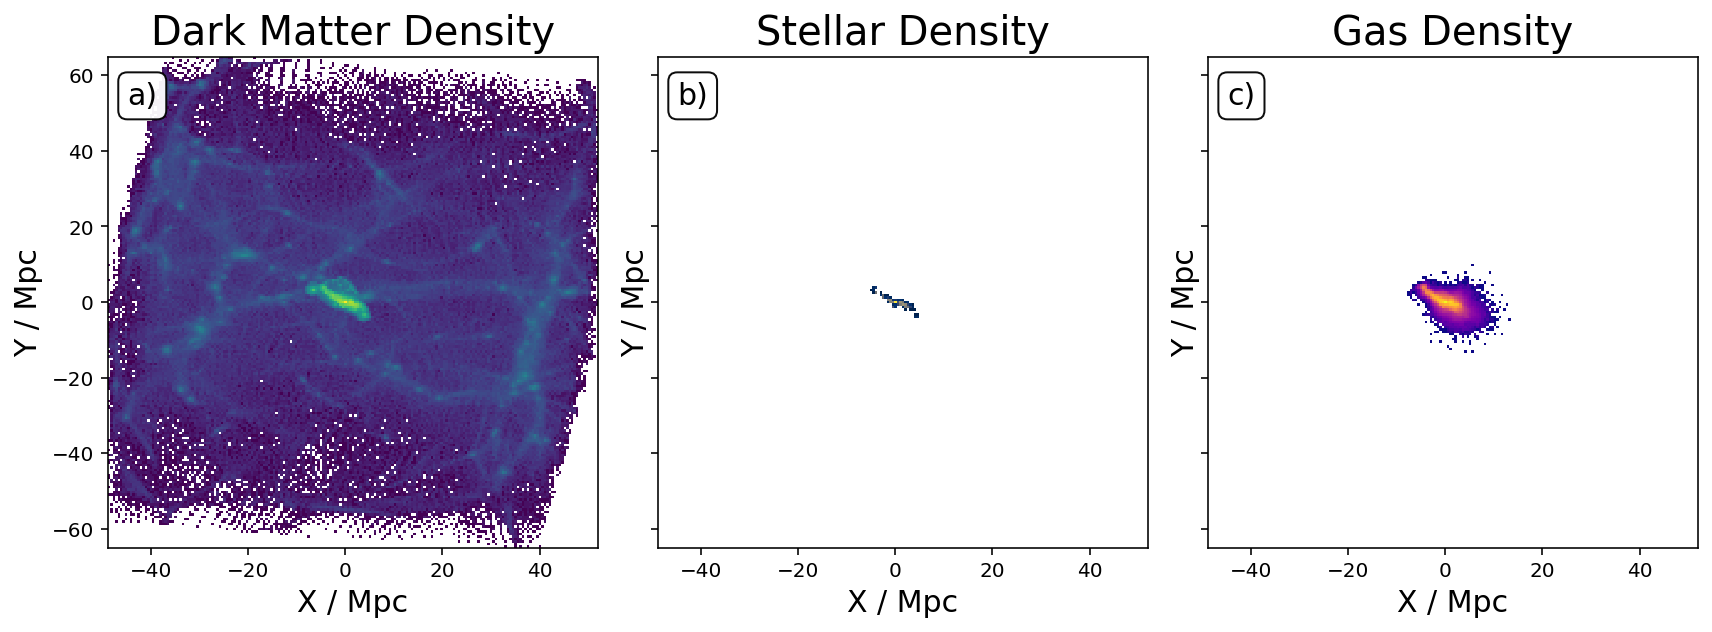

In [8]:
# How did we reposition and rotate the full simulation?
hist2d_darkmatter_stars_gas(simulation_full)

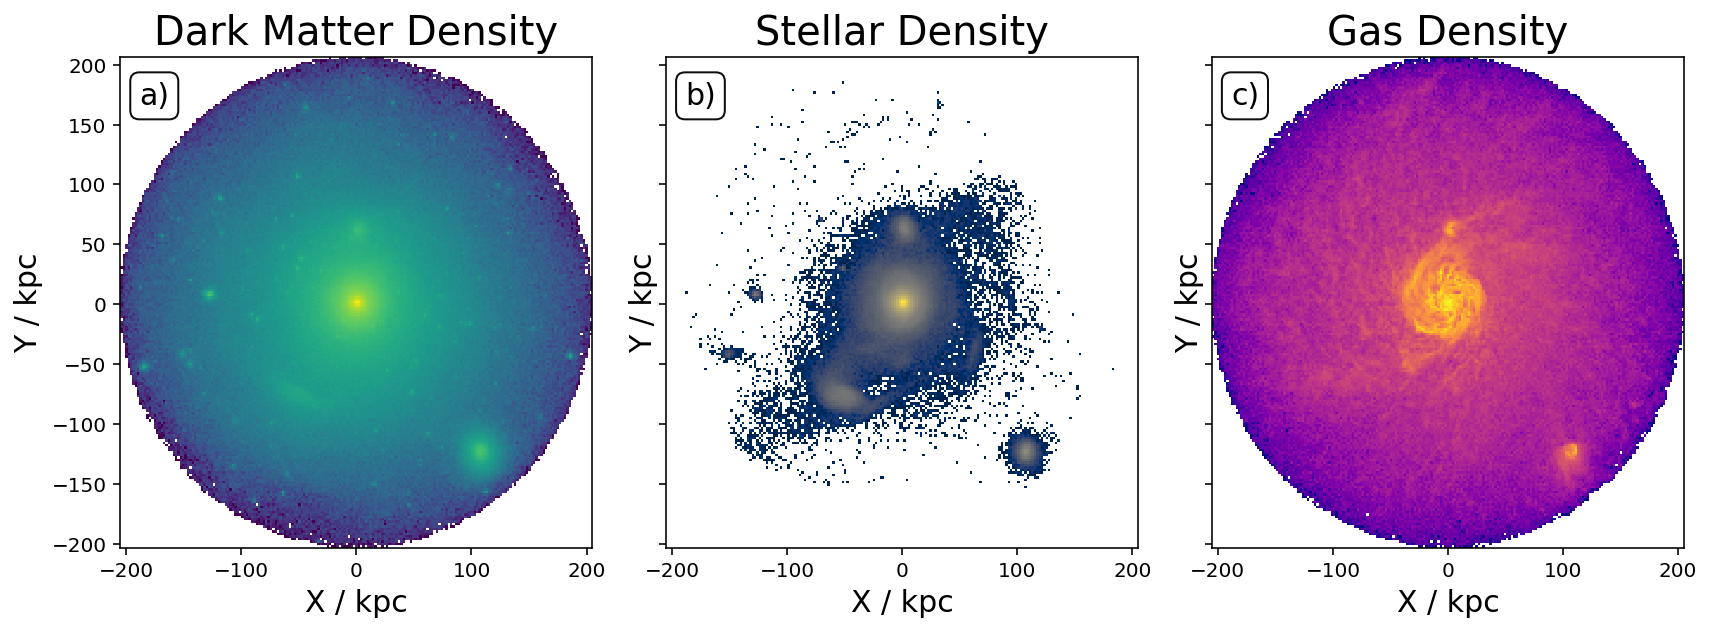

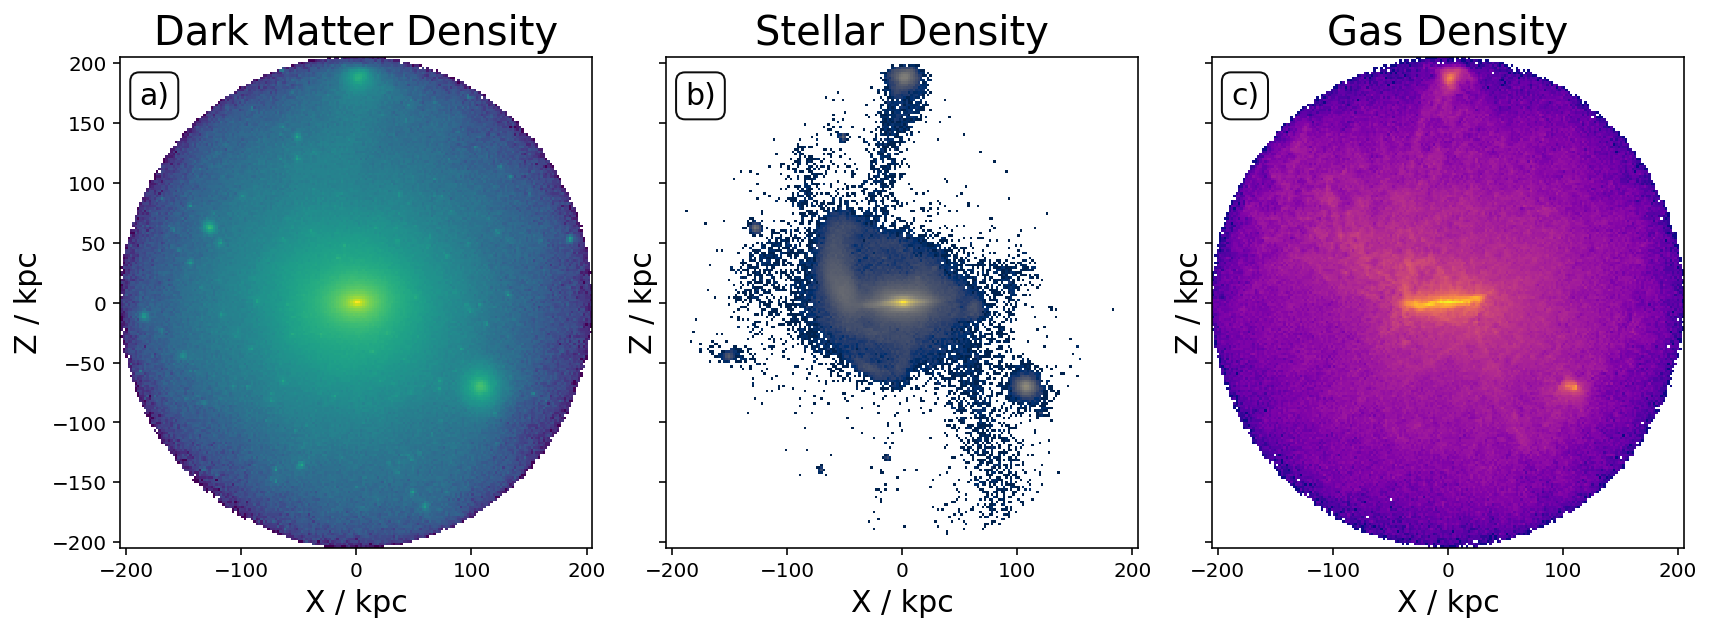

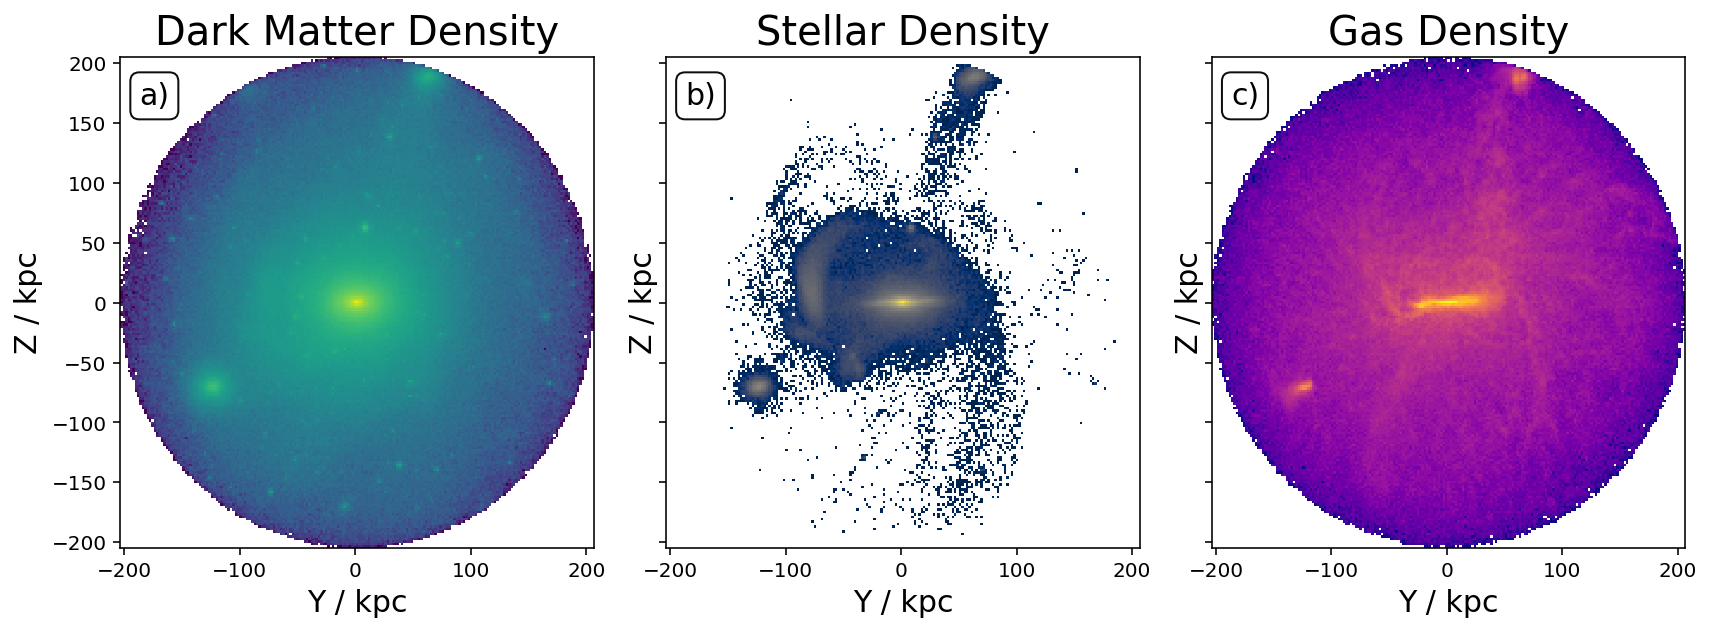

In [9]:
# Is the main halo now face on?
hist2d_darkmatter_stars_gas(main_halo, frame = 'xy')
hist2d_darkmatter_stars_gas(main_halo, frame = 'xz')
hist2d_darkmatter_stars_gas(main_halo, frame = 'yz')

In [10]:
# Calculate the total mass of the halo
total_mass = main_halo['mass'].sum()

# Calculate the cumulative mass profile
radii = main_halo['r'].in_units('kpc')
sorted_indices = np.argsort(radii)
sorted_radii = radii[sorted_indices]
sorted_masses = main_halo['mass'][sorted_indices]
cumulative_mass = np.cumsum(sorted_masses)

# Find the half-mass radius
half_mass = total_mass / 2.0
half_mass_radius = np.interp(half_mass, cumulative_mass, sorted_radii)

print('Half Mass Radius: '+"{:.1f}".format(half_mass_radius)+' kpc')

Half Mass Radius: 71.5 kpc


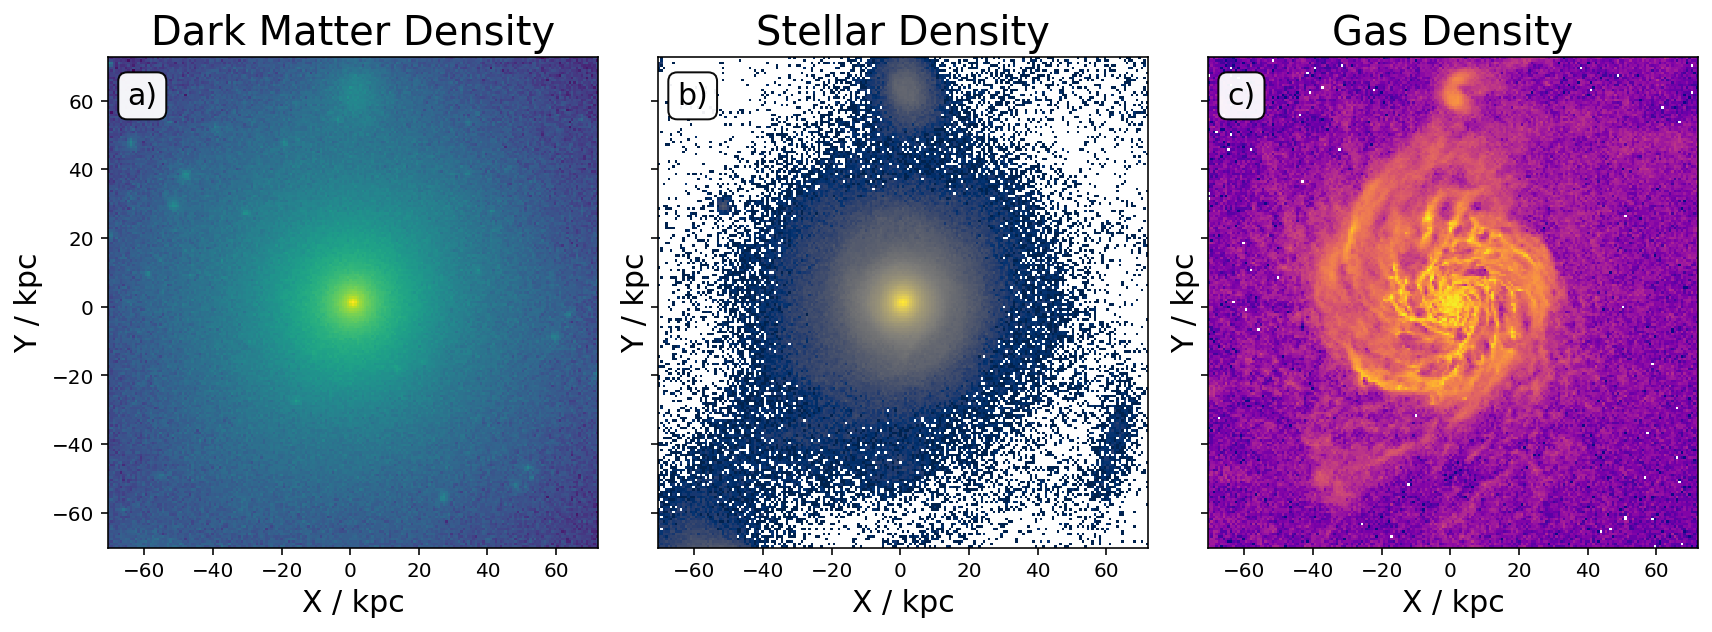

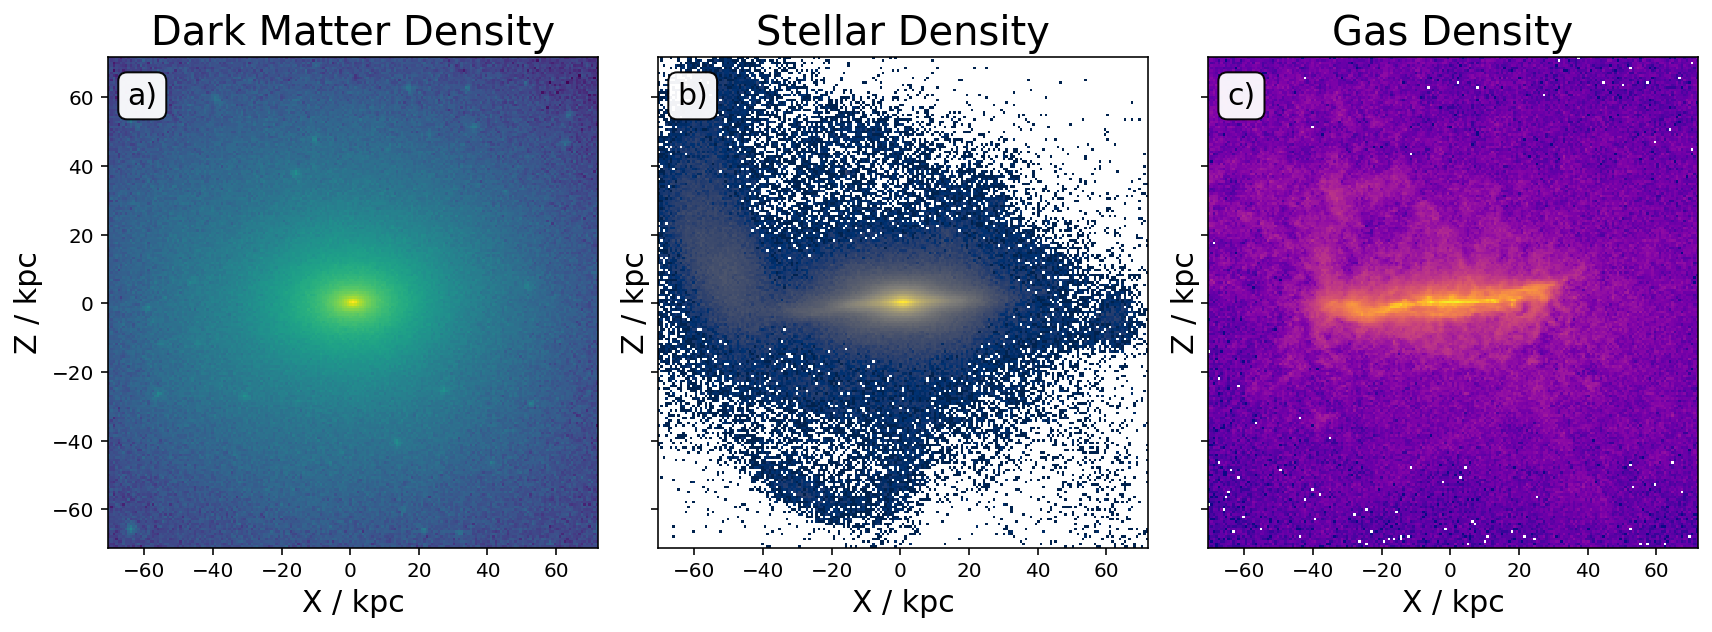

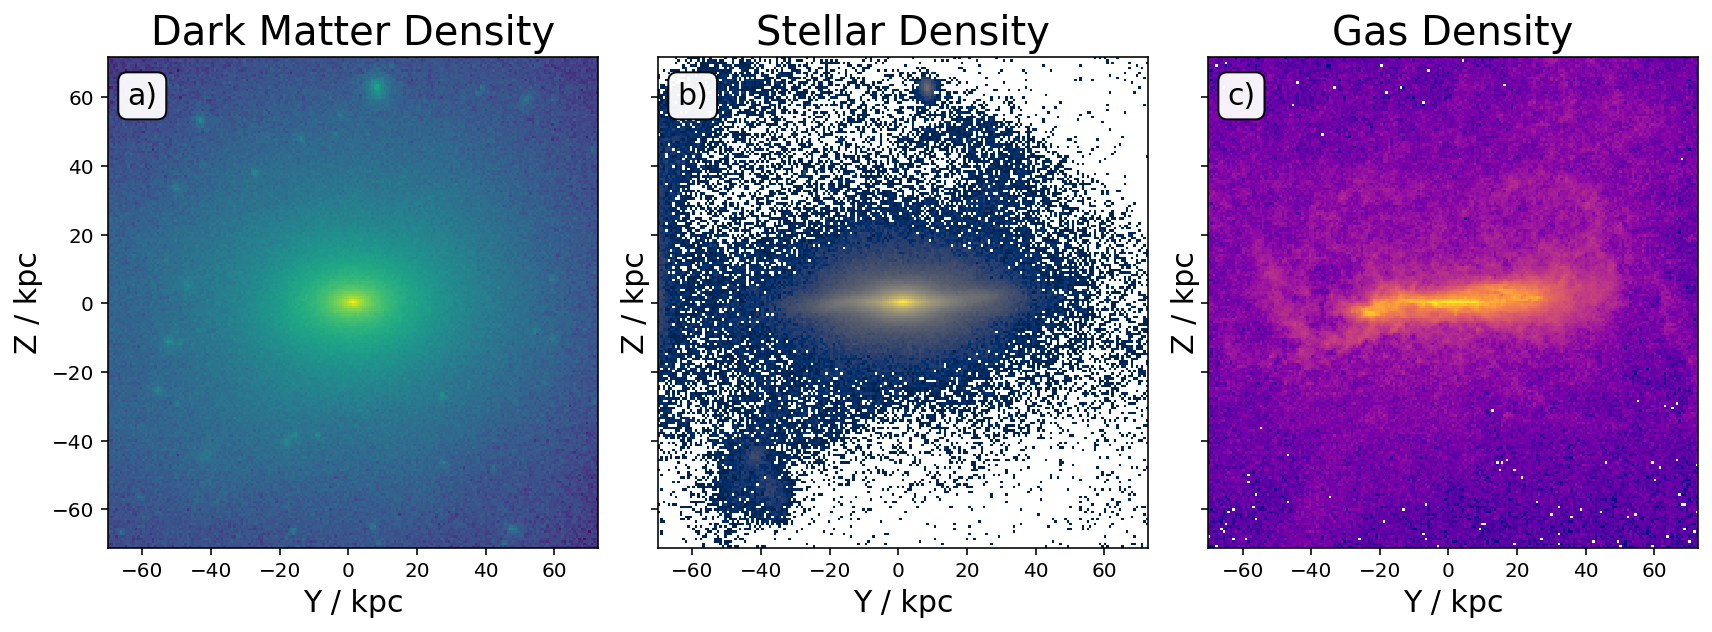

In [11]:
# Is the main halo now face on?
hist2d_darkmatter_stars_gas(main_halo, frame = 'xy', effective_radius=half_mass_radius, saveas=simulation_name+'_darkmatter_stars_gas_xy_1re')
hist2d_darkmatter_stars_gas(main_halo, frame = 'xz', effective_radius=half_mass_radius,saveas=simulation_name+'_darkmatter_stars_gas_xz_1re')
hist2d_darkmatter_stars_gas(main_halo, frame = 'yz', effective_radius=half_mass_radius,saveas=simulation_name+'_darkmatter_stars_gas_yz_1re')

# 3. Chemistry

Elemental abundances can be reported with 2 definitions.

In stellar spectroscopy, the definition via number densities (N_X) is more common:

```
   A(X) = log10(N_X / N_H) + 12
  [X/H] = A(X) - A(X_Sun)  
 [X/Fe] = [X/H] - [Fe/H]
```

In stellar evolution, the definition via mass fractions is more common:

```
    m_X = mass(X) / mass(total)  
m_H_Sun = 0.74
m_X_Sun = 10^(A(X) - 12) * u_mass(X) * m_H_Sun
```

To convert between mass fraction and number density, the following relationship can be used:
```
  [X/H] = log10(m_X / m_H) - log10(m_X_Sun / m_H_Sun)
```

In [12]:
# Abundances are reported in mass fractions.
# To convert to number densities, we need to convert via solar abundance x and atomic mass m.

# Atomic masses:
atomic_masses = {
    'H'  :   1.008, 'He' :   4.003, 'Li' :   6.941, 'Be' :   9.012,\
    'B'  :  10.811, 'C'  :  12.011, 'N'  :  14.007, 'O'  :  15.999,\
    'F'  :  18.998, 'Ne' :  20.180, 'Na' :  22.990, 'Mg' :  24.305,\
    'Al' :  26.982, 'Si' :  28.086, 'P'  :  30.974, 'S'  :  32.066,\
    'Cl' :  35.453, 'Ar' :  39.948, 'K'  :  39.098, 'Ca' :  40.078,\
    'Sc' :  44.956, 'Ti' :  47.867, 'V'  :  50.942, 'Cr' :  51.996,\
    'Mn' :  54.938, 'Fe' :  55.845, 'Co' :  58.933, 'Ni' :  58.693,\
    'Cu' :  63.546, 'Zn' :  65.380, 'Ga' :  69.723, 'Ge' :  72.631,\
    'As' :  74.922, 'Se' :  78.971, 'Br' :  79.904, 'Kr' :  84.798,\
    'Rb' :  84.468, 'Sr' :  87.620, 'Y'  :  88.906, 'Zr' :  91.224,\
    'Nb' :  92.906, 'Mo' :  95.950, 'Tc' :  98.907, 'Ru' : 101.070,\
    'Rh' : 102.906, 'Pd' : 106.420, 'Ag' : 107.868, 'Cd' : 112.414,\
    'In' : 114.818, 'Sn' : 118.711, 'Sb' : 121.760, 'Te' : 126.700,\
    'I'  : 126.904, 'Xe' : 131.294, 'Cs' : 132.905, 'Ba' : 137.328,\
    'La' : 138.905, 'Ce' : 140.116, 'Pr' : 140.908, 'Nd' : 144.243,\
    'Pm' : 144.913, 'Sm' : 150.360, 'Eu' : 151.964, 'Gd' : 157.250 \
}

# Solar abundances from Asplund+2009
solar_abund = {
    'H'  : 12.00, 'He' : 10.93, 'Li' : 1.05, 'Be' : 1.38, 'B'  : 2.70,
    'C'  : 8.43,  'N'  : 7.83,  'O'  : 8.69,  'F'  : 4.56, 'Ne' : 7.93,
    'Na' : 6.24,  'Mg' : 7.60,  'Al' : 6.45,  'Si' : 7.51, 'P'  : 5.41,
    'S'  : 7.12,  'Cl' : 5.50,  'Ar' : 6.40,  'K'  : 5.03, 'Ca' : 6.34,
    'Sc' : 3.15,  'Ti' : 4.95,  'V'  : 3.93,  'Cr' : 5.64, 'Mn' : 5.43,
    'Fe' : 7.50,  'Co' : 4.99,  'Ni' : 6.22,  'Cu' : 4.19, 'Zn' : 4.56,
    'Ga' : 3.04,  'Ge' : 3.65,  'As' : 2.30,  'Se' : 3.34, 'Br' : 2.54,
    'Kr' : 3.25,  'Rb' : 2.36,  'Sr' : 2.87,  'Y'  : 2.21, 'Zr' : 2.58,
    'Nb' : 1.46,  'Mo' : 1.88,  'Ru' : 1.75,  'Rh' : 0.91, 'Pd' : 1.57,
    'Ag' : 0.94,  'Cd' : 1.71,  'In' : 0.80,  'Sn' : 2.04, 'Sb' : 1.01,
    'Te' : 2.18,  'I'  : 1.55,  'Xe' : 2.24,  'Cs' : 1.08, 'Ba' : 2.18,
    'La' : 1.10,  'Ce' : 1.58,  'Pr' : 0.72,  'Nd' : 1.42, 'Sm' : 0.96,
    'Eu' : 0.52,  'Gd' : 1.07
}

element_mass_to_density = dict()

for element in solar_abund.keys():
    if element == 'H':
        element_mass_to_density['H'] = 0.74
    else:
        element_mass_to_density[element] = 10**(solar_abund[element]-12.0) * atomic_masses[element] * element_mass_to_density['H']

In [13]:
# Create the function to convert elemental mass fractions to [X/H] elemental abundances with "element" as argument
@TipsySnap.derived_quantity
def X_H(self, element, minimum_X_H = -5.0):
    min_MassFrac = np.amin(self[element+'MassFrac'][np.where(self[element+'MassFrac'] > 0)])
    self[element+'MassFrac'][np.where(self[element+'MassFrac'] == 0)] = min_MassFrac
    return (np.log10((self[element+'MassFrac']) / self['hydrogen']) - np.log10(element_mass_to_density[element] / element_mass_to_density['H'])).clip(min=minimum_X_H)

In [14]:
for element in [
    'He',
    'C','N','O','Ne',
    'Na','Mg','Al','Si','S','Cl',
    'Ti','Mn','Fe','Ni','Cu','Zn',
    'Y',
    'Ba','Ce','Eu'
]:
    main_halo.s[element+'_H'] = X_H(main_halo.s, element)
    
    # For Section 5 below, we also compute [Fe/H] for the full simulation, to see what we are missing out on, 
    # when limiting ourselves to the main halo.
    if element == 'Fe':
        simulation_full.s[element+'_H'] = X_H(simulation_full.s, element)

# 4. Save all relevant information in a FITS Table with physical units

In [15]:
simulation_lite_stars = Table()

for pos in ['x','y','z']:
    simulation_lite_stars[pos] = main_halo.s[pos].in_units('kpc')
    simulation_lite_stars['v'+pos] = main_halo.s['v'+pos].in_units('km s**-1')

simulation_lite_stars['potential_phi'] = main_halo.s['phi'].in_units('km**2 s**-2')
simulation_lite_stars['mass'] = main_halo.s['mass'].in_units('Msol')
simulation_lite_stars['age'] = main_halo.s['age'].in_units('Gyr')

simulation_lite_stars['meallicity_z'] = main_halo.s['metals']

for element in [
    'He',
    'C','N','O','Ne',
    'Na','Mg','Al','Si','S','Cl',
    'Ti','Mn','Fe','Ni','Cu','Zn',
    'Y',
    'Ba','Ce','Eu'
]:
    simulation_lite_stars[element+'_H'] = main_halo.s[element+'_H']

In [16]:
simulation_lite_stars.write('NIHAO_prepared/'+simulation_name+'_stars.fits',overwrite=True)

# 5. Gas information

In [17]:
simulation_lite_gas = Table()

for pos in ['x','y','z']:
    simulation_lite_gas[pos] = main_halo.gas[pos].in_units('kpc')
    simulation_lite_gas['v'+pos] = main_halo.gas['v'+pos].in_units('km s**-1')

simulation_lite_gas['potential_phi'] = main_halo.gas['phi'].in_units('km**2 s**-2')
simulation_lite_gas['mass'] = main_halo.gas['mass'].in_units('Msol')
simulation_lite_gas['temperature'] = main_halo.gas['temp'].in_units('K')
simulation_lite_gas['density_rho'] = main_halo.gas['rho'].in_units('Msol kpc**-3')

simulation_lite_gas['meallicity_z'] = main_halo.gas['metals']

In [18]:
simulation_lite_gas.write('NIHAO_prepared/'+simulation_name+'_gas.fits',overwrite=True)

# 6. Age/Redshift-Metallicity-Relation (full simulation vs. main halo)

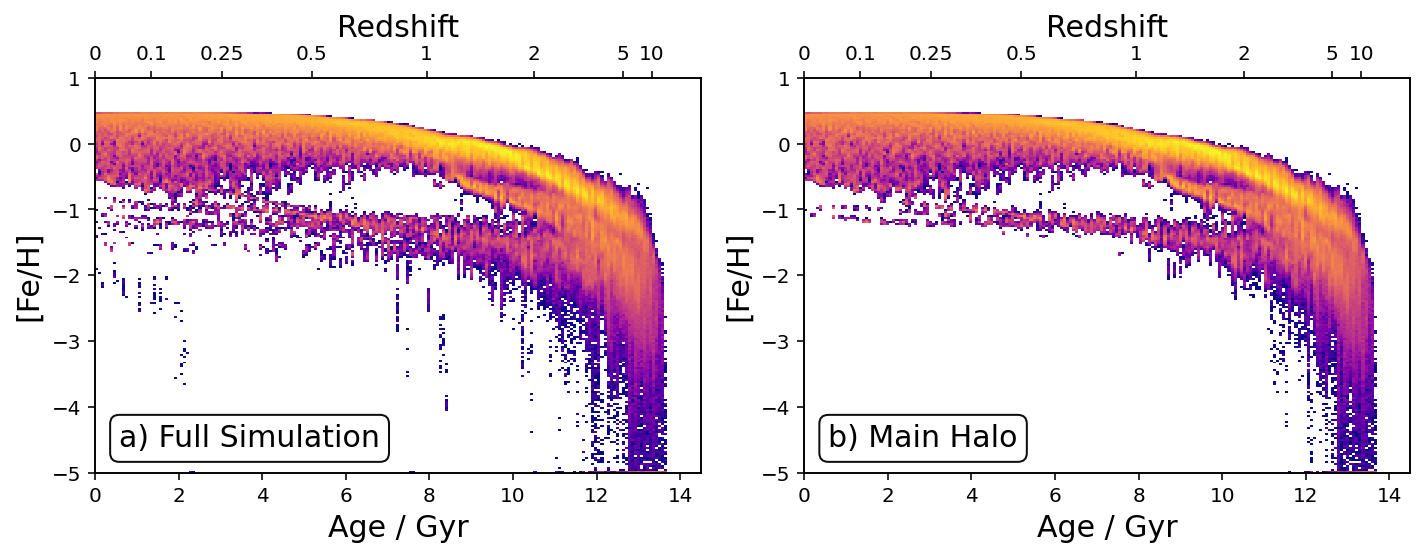

In [19]:
def plot_age_metallicity_relation(saveas=False):

    f, gs = plt.subplots(1,2,figsize=(10,4))#,sharex=True,sharey=True)

    ax = gs[0]
    ax.text(0.04,0.05,panels[0]+' Full Simulation',fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')

    ax.hist2d(
        simulation_full.s['age'].in_units('Gyr'),
        simulation_full.s['Fe_H'],
        bins = (np.linspace(0,14.5,200),np.linspace(-5.0,1.0,200)),
        cmin = 1, norm = LogNorm(),
        cmap = 'plasma'
    )

    # Create the secondary x-axis (redshift)
    ax2 = ax.twiny()
    # Set the redshift labels and ticks
    redshift_ticks = [0,0.1,0.25,0.5,1,2,5,10]  # Redshift ticks as integers
    age_ticks = [cosmo.age(0).value-cosmo.age(z).value for z in redshift_ticks]
    ax2.set_xticks(age_ticks)
    ax2.set_xticklabels(redshift_ticks)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel('Redshift')

    ax = gs[1]
    ax.text(0.04,0.05,panels[1]+' Main Halo',fontsize=15,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel('Age / Gyr')
    ax.set_ylabel('[Fe/H]')

    ax.hist2d(
        simulation_lite_stars['age'],
        simulation_lite_stars['Fe_H'],
        bins = (np.linspace(0,14.5,200),np.linspace(-5.0,1.0,200)),
        cmin = 1, norm = LogNorm(),
        cmap = 'plasma'
    )

    # Create the secondary x-axis (redshift)
    ax2 = ax.twiny()
    # Set the redshift labels and ticks
    redshift_ticks = [0,0.1,0.25,0.5,1,2,5,10]  # Redshift ticks as integers
    age_ticks = [cosmo.age(0).value-cosmo.age(z).value for z in redshift_ticks]
    ax2.set_xticks(age_ticks)
    ax2.set_xticklabels(redshift_ticks)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel('Redshift')

    plt.tight_layout()
    if saveas:
        plt.savefig('NIHAO_prepared/'+saveas + '.png', dpi=300, bbox_inches='tight')        

plot_age_metallicity_relation(saveas=simulation_name+'_age_metallicity_relation')